In [80]:
import os
import sys

# 当引用模块和运行的脚本不在同一个目录下，需在脚本开头添加如下代码：
sys.path.append('/home/mt/learn/SSD-Tensorflow-master/')
import cv2
import math
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as mpcm
import matplotlib.image as mpimg
from notebooks import visualization
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing

slim = tf.contrib.slim

# TensorFlow session
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)


/home/mt/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [92]:
# l_VOC_CLASS =  ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
#                'bus', 'car', 'cat', 'chair', 'cow',
#                'diningTable', 'dog', 'horse', 'motorbike', 'person',
#                'pottedPlant', 'sheep', 'sofa', 'train', 'TV']
# 定义数据格式，设置占位符
net_shape = (300, 300)

# 预处理，以Tensorflow backend, 将输入图片大小改成 300x300，作为下一步输入
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))

# 输入图像的通道排列形式，'NHWC'表示 [batch_size,height,width,channel]
data_format = 'NHWC'

# 数据预处理，将img_input输入的图像resize为300大小，labels_pre,bboxes_pre,bbox_img待解析
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format,
    resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)

# 拓展为4维变量用于输入
image_4d = tf.expand_dims(image_pre, 0)

In [ ]:
# 定义SSD模型
# 是否复用，目前我们没有在训练所以为None
reuse = True if 'ssd_net' in locals() else None
# 调出基于VGG神经网络的SSD模型对象，注意这是一个自定义类对象
ssd_net = ssd_vgg_300.SSDNet()
# 得到预测类和预测坐标的Tensor对象，这两个就是神经网络模型的计算流程
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# 导入官方给出的 SSD 模型参数
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# 在网络模型结构中，提取搜索网格的位置
# 根据模型超参数，得到每个特征层（这里用了6个特征层，分别是4，7，8，9，10，11）的anchors_boxes
ssd_anchors = ssd_net.anchors(net_shape)

In [100]:
# 加载辅助作图函数
def colors_subselect(colors, num_classes=1):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i * dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
#         for a in range(classes.shape[0]):
#             cls_id = int(classes[a])
#         if cls_id == 15:
        if classes[i]==15:
            bbox = bboxes[i]
            color = colors[classes[i]]
            # Draw bounding box...
            p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
            p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
            cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
            # Draw text...
            s = '%s/%.3f' % (l_VOC_CLASS[int(classes[i]) - 1], scores[i])
            p1 = (p1[0] - 5, p1[1])
            # cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 1.5, color, 3)


colors_plasma = colors_subselect(mpcm.plasma.colors, num_classes=27)

In [101]:
# 主流程函数
def process_image(img, case, select_threshold=0.15, nms_threshold=.1, net_shape=(300, 300)):
    # select_threshold：box阈值——每个像素的box分类预测数据的得分会与box阈值比较，高于一个box阈值则认为这个box成功框到了一个对象
    # nms_threshold：重合度阈值——同一对象的两个框的重合度高于该阈值，则运行下面去重函数

    # 执行SSD模型，得到4维输入变量，分类预测，坐标预测，rbbox_img参数为最大检测范围，本文固定为[0,0,1,1]即全图
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions,
                                                               localisations, bbox_img], feed_dict={img_input: img})

    # ssd_bboxes_select()函数根据每个特征层的分类预测分数，归一化后的映射坐标，
    # ancohor_box的大小，通过设定一个阈值计算得到每个特征层检测到的对象以及其分类和坐标
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(rpredictions, rlocalisations, ssd_anchors,
                                                              select_threshold=select_threshold,
                                                              img_shape=net_shape,
                                                              num_classes=21, decode=True)

    """
    这个函数做的事情比较多，这里说的细致一些：
    首先是输入，输入的数据为每个特征层（一共6个，见上文）的：
                                                rpredictions: 分类预测数据，
                                                rlocalisations: 坐标预测数据，
                                                ssd_anchors: anchors_box数据
                                            其中：
                                               分类预测数据为当前特征层中每个像素的每个box的分类预测
                                               坐标预测数据为当前特征层中每个像素的每个box的坐标预测
                                               anchors_box数据为当前特征层中每个像素的每个box的修正数据

        函数根据坐标预测数据和anchors_box数据，计算得到每个像素的每个box的中心和长宽，这个中心坐标和长宽会根据一个算法进行些许的修正，
    从而得到一个更加准确的box坐标；修正的算法会在后文中详细解释，如果只是为了理解算法流程也可以不必深究这个，因为这个修正算法属于经验算
    法，并没有太多逻辑可循。
        修正完box和中心后，函数会计算每个像素的每个box的分类预测数据的得分，当这个分数高于一个阈值（这里是0.5）则认为这个box成功
    框到了一个对象，然后将这个box的坐标数据，所属分类和分类得分导出，从而得到：
        rclasses：所属分类
        rscores：分类得分
        rbboxes：坐标

        最后要注意的是，同一个目标可能会在不同的特征层都被检测到，并且他们的box坐标会有些许不同，这里并没有去掉重复的目标，而是在下文
    中专门用了一个函数来去重
    """

    # 检测有没有超出检测边缘
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    # 去重，将重复检测到的目标去掉
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # 将box的坐标重新映射到原图上（上文所有的坐标都进行了归一化，所以要逆操作一次）
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)

    if case == 1:
        bboxes_draw_on_img(img, rclasses, rscores, rbboxes, colors_plasma, thickness=8)
        return img
    else:
        return rclasses, rscores, rbboxes


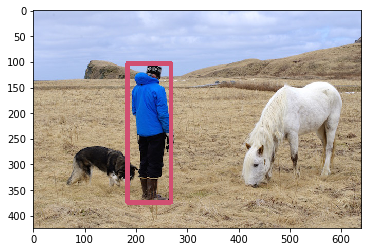

In [102]:
"""
# 只做目标定位，不做预测分析
case = 1
img = cv2.imread("../demo/person.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(process_image(img, case))
plt.show()
"""
# 做目标定位，同时做预测分析
case = 1
path = '../demo/person.jpg'
# 读取图片
img = mpimg.imread(path)
# 执行主流程函数
# rclasses, rscores, rbboxes = process_image(img, case)
image = process_image(img, case)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
# 显示分类结果图
# visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
plt.imshow(image)
plt.show()